<a href="https://colab.research.google.com/github/Thiag-0/Redes-Neurais-Recorrentes/blob/main/RNN_Acoes_Petrobras_By_Thiago_Silva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Previsão de Séries Temporais com RNN \\
Estudo de caso - Ações Petrobras \\
Referência: https://www.youtube.com/watch?v=iP4323wII-I


# Carregamento dos Dados

In [4]:
import pandas as pd
df = pd.read_csv("PETR4.SA2.csv")

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,13.660646,30182600
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,14.153233,30552600
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,14.174045,36141000
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,13.931217,28069600
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,13.528824,29091300


# Tem linha do dataframe com dados faltando?

In [5]:
df[df.isna().any(axis=1)] #verifica qual linha é

,Date,Open,High,Low,Close,Adj Close,Volume


In [6]:
df = df.dropna()

len(df)

2234

In [7]:
prices = df['Close']

# Visualização dos Dados

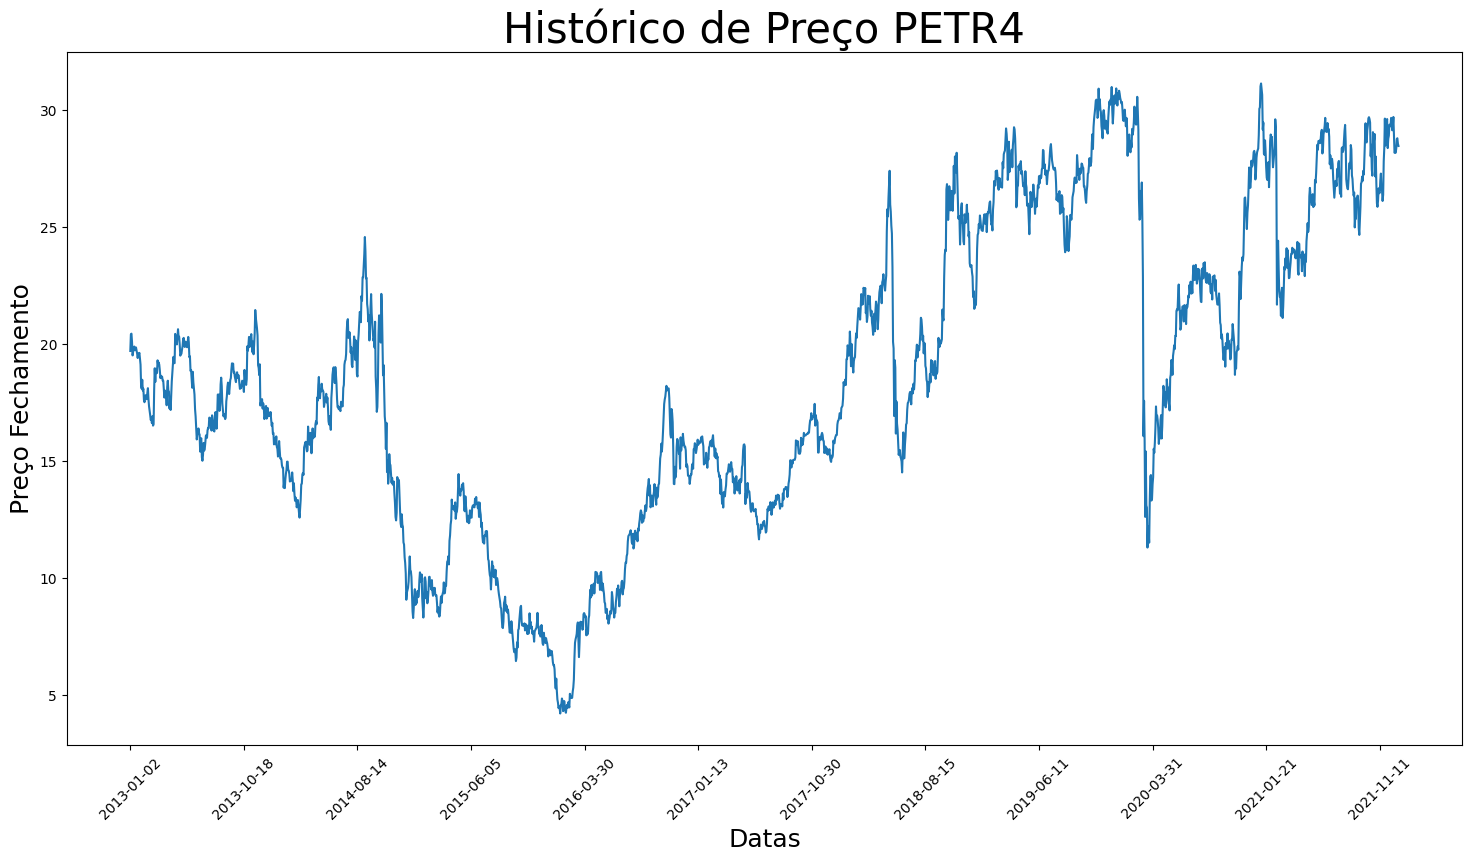

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'])
plt.xticks(range(0,df.shape[0],200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Fechamento', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.show()

In [9]:
days_time_step = 15
forecast_horizon = 7  # Prevê 7 dias à frente

# Separação Teste e Treino

In [10]:
import numpy as np
training_size = int(len(prices) * 0.95)
test_size = len(prices) - training_size
train_data, input_data = np.array(prices[0:training_size]), np.array(prices[training_size - days_time_step:])
test_data = np.array(prices[training_size:])

train_data.shape, test_data.shape

((2122,), (112,))

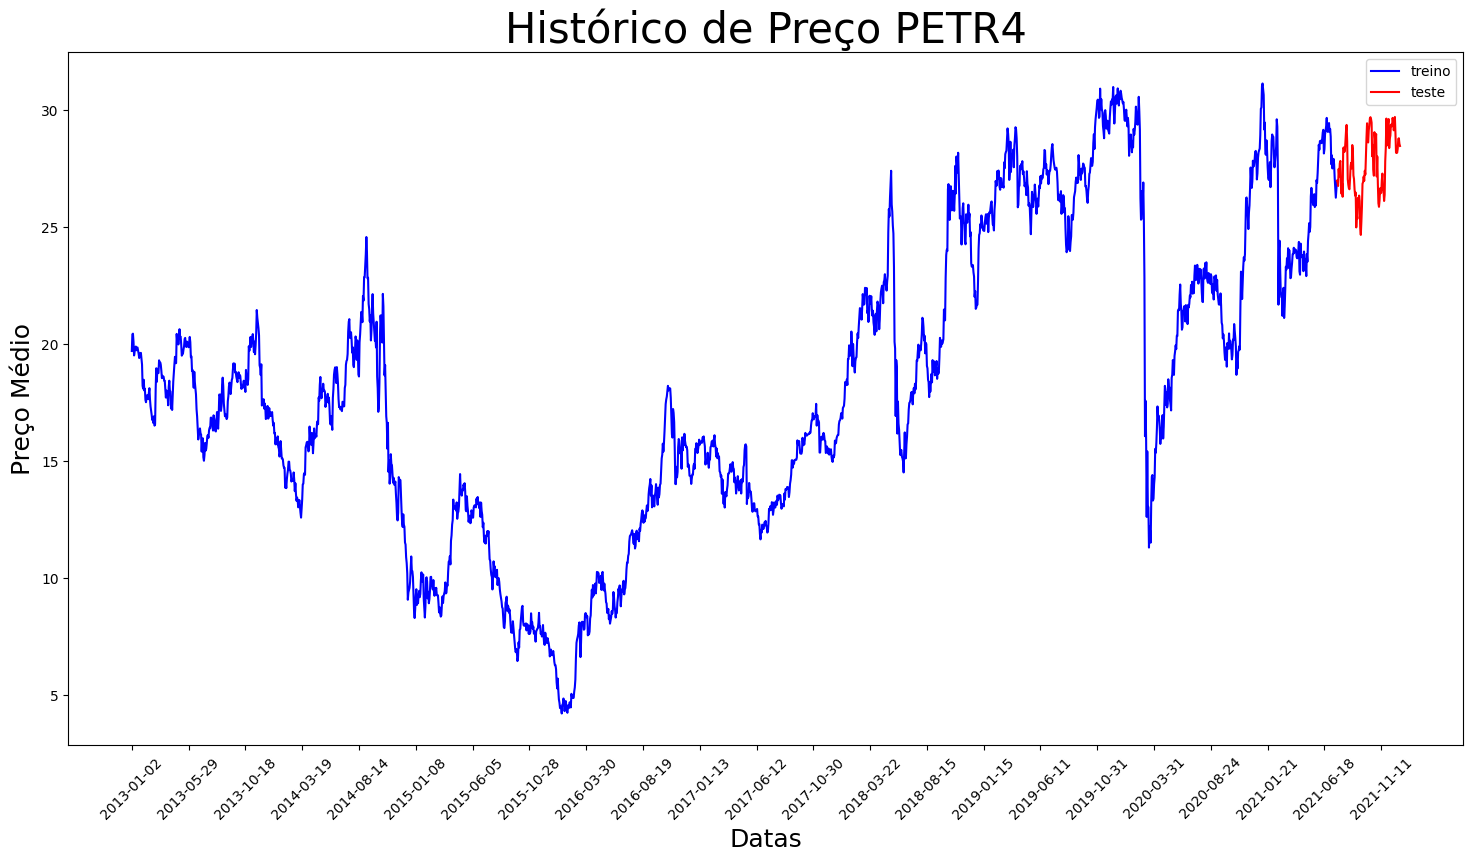

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'].loc[0:train_data.shape[0]], color = 'blue', label = 'treino')
plt.plot(df['Close'].loc[train_data.shape[0]:], color = 'red', label = 'teste')
plt.xticks(range(0,df.shape[0],100), df['Date'].loc[::100], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

# Normalização dos Dados

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data_norm = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_norm = scaler.transform(np.array(input_data).reshape(-1,1))
val_data_norm = scaler.transform(np.array(test_data).reshape(-1,1))

train_data_norm

array([[0.57540863],
       [0.60178304],
       [0.60289745],
       ...,
       [0.83506683],
       [0.81872211],
       [0.83172359]])

# Pré-processamento (Gerando X e y)

In [13]:
#treino
X_train, y_train = [], []
for i in range(len(train_data_norm) - days_time_step - forecast_horizon):
    X_train.append(train_data_norm[i:i+days_time_step])
    y_train.append(train_data_norm[i+days_time_step:i+days_time_step+forecast_horizon])

X_train, y_train = np.array(X_train), np.array(y_train)


#teste
X_test, y_test = [], []
for i in range(len(test_data_norm) - days_time_step - forecast_horizon):
    X_test.append(test_data_norm[i:i+days_time_step])
    y_test.append(test_data_norm[i+days_time_step:i+days_time_step+forecast_horizon])

X_test, y_test = np.array(X_test), np.array(y_test)


#val
X_val, y_val = [], []
for i in range(len(val_data_norm) - days_time_step - forecast_horizon):
    X_val.append(val_data_norm[i:i+days_time_step])
    y_val.append(val_data_norm[i+days_time_step:i+days_time_step+forecast_horizon])

X_val, y_val = np.array(X_val), np.array(y_val)


#converter tudo pra matriz numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test.shape

(105, 15, 1)

# Treinamento de Rede Neural

In [14]:
import tensorflow as tf

tf.__version__

'2.18.0'

In [16]:
from tensorflow.keras.layers import LSTM

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM  # Import LSTM here

model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(days_time_step, 1)))
model.add(Dense(forecast_horizon))
model.compile(loss='mse', optimizer='adam')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,507 (162.14 KB)

 Trainable params: 41,507 (162.14 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1133 - val_loss: 0.0036
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 12/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val

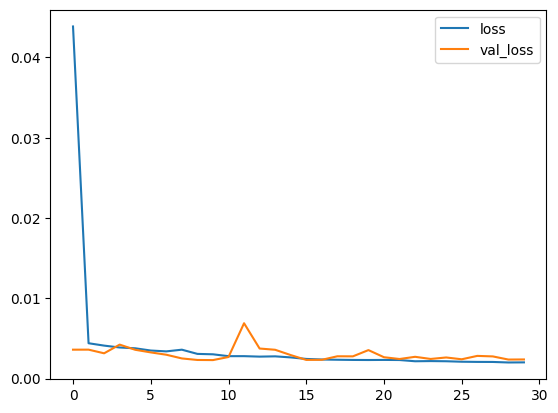

In [19]:
import matplotlib.pyplot as plt

plt.plot(h.history["loss"], label='loss')
plt.plot(h.history["val_loss"], label='val_loss')
plt.legend()

# Avaliação de Resultados

In [20]:
#predição de valores pela rede
predict = model.predict(X_test)

#transformação inversa do normalizador, pra que possamos plotar no gráfico os resultados
predict = scaler.inverse_transform(predict.reshape(-1, forecast_horizon))
real = test_data

predict.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


(105, 7)

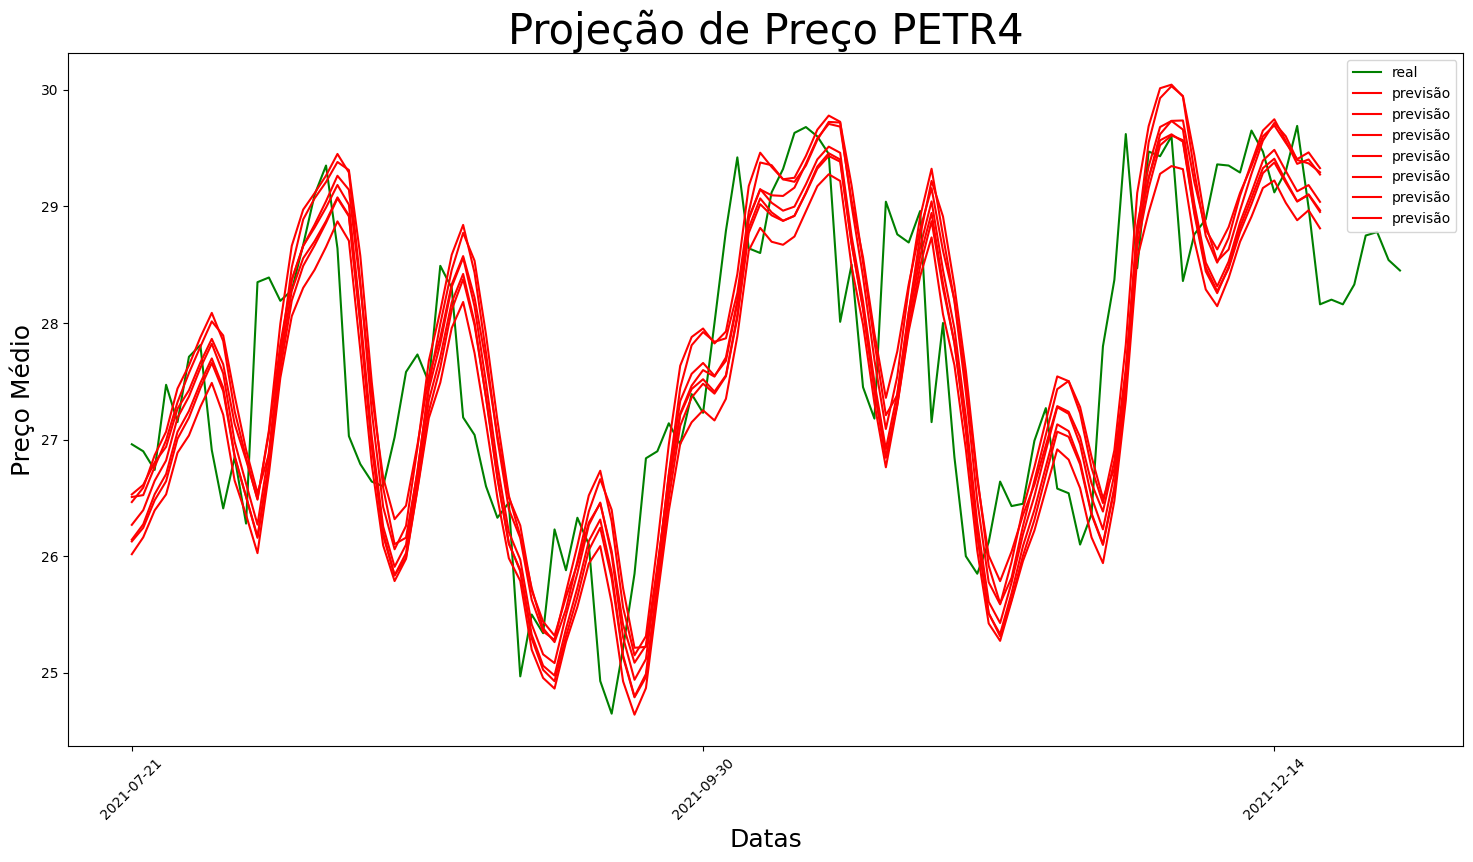

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(real, color = 'green', label = 'real')
plt.plot(predict, color = 'red', label = 'previsão')
plt.xticks(range(0, len(real), 50), df['Date'].iloc[- len(real)::50], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Projeção de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

In [22]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
mse_per_day = [mean_squared_error(y_test[:, i], predict[:, i]) for i in range(forecast_horizon)]
print("MSE por dia:", mse_per_day)

MSE por dia: [722.4673770882256, 699.6249047014206, 707.2518637063213, 708.9055577846821, 714.3340405700432, 725.7471192393997, 727.4127679986408]


# Referências

* https://www.datacamp.com/community/tutorials/lstm-python-stock-market
* https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/#:~:text=LSTMs%20are%20widely%20used%20for,the%20information%20that%20is%20not.
* https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/
* https://medium.com/alexandre-george-lustosa/previs%C3%A3o-de-pre%C3%A7o-petr4-com-python-lstm-f93722be59e0
* https://finance.yahoo.com/quote/PETR4.SA/history?period1=1356998400&period2=1640995200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
* http://revistagt.fpl.edu.br/get/article/view/1930/1230